# Forward Implied Distribution for Interest Rate Options

This notebook implements a function to compute the forward implied distribution for interest rate options using normal volatilities. 

## Problem Setup
- We have implied volatilities for T=1 and T=2 (with potential vol smile across strikes)
- We want to compute the distribution at T=2 conditional on a specific move at T=1
- All volatilities are normal (appropriate for interest rates)
- We need to extract the forward distribution from T=1 to T=2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize
from scipy.interpolate import interp1d, CubicSpline
from typing import Optional, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [19]:
def normal_option_price(forward: float, strike: float, vol: float, time: float, option_type: str = 'call') -> float:
    """
    Price European option under normal (Bachelier) model.
    
    Parameters:
    -----------
    forward : float
        Forward rate
    strike : float  
        Strike rate
    vol : float
        Normal volatility (in basis points)
    time : float
        Time to expiry
    option_type : str
        'call' or 'put'
        
    Returns:
    --------
    float
        Option price
    """
    if time <= 0:
        if option_type == 'call':
            return max(forward - strike, 0)
        else:
            return max(strike - forward, 0)
    
    std_dev = vol * np.sqrt(time)
    if std_dev == 0:
        if option_type == 'call':
            return max(forward - strike, 0)
        else:
            return max(strike - forward, 0)
    
    d = (forward - strike) / std_dev
    
    if option_type == 'call':
        return (forward - strike) * stats.norm.cdf(d) + std_dev * stats.norm.pdf(d)
    else:
        return (strike - forward) * stats.norm.cdf(-d) + std_dev * stats.norm.pdf(d)

def normal_option_delta(forward: float, strike: float, vol: float, time: float, option_type: str = 'call') -> float:
    """
    Calculate delta of European option under normal model.
    """
    if time <= 0:
        if option_type == 'call':
            return 1.0 if forward > strike else 0.0
        else:
            return -1.0 if forward < strike else 0.0
    
    std_dev = vol * np.sqrt(time)
    if std_dev == 0:
        if option_type == 'call':
            return 1.0 if forward > strike else 0.0
        else:
            return -1.0 if forward < strike else 0.0
    
    d = (forward - strike) / std_dev
    
    if option_type == 'call':
        return stats.norm.cdf(d)
    else:
        return -stats.norm.cdf(-d)

In [20]:
def extract_risk_neutral_density(strikes: np.ndarray, option_prices: np.ndarray, 
                                   forward: float, time: float, option_type: str = 'call',
                                   smoothing_method: str = 'cubic_spline') -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract risk-neutral density from option prices using finite differences.
    
    For call options: density = exp(r*T) * d²C/dK²
    For put options: density = exp(r*T) * d²P/dK²
    
    Parameters:
    -----------
    strikes : np.ndarray
        Strike prices
    option_prices : np.ndarray
        Option prices
    forward : float
        Forward rate
    time : float
        Time to expiry
    option_type : str
        'call' or 'put'
    smoothing_method : str
        'cubic_spline' or 'linear'
        
    Returns:
    --------
    Tuple[np.ndarray, np.ndarray]
        (strike_grid, density_values)
    """
    # Sort by strikes
    sorted_idx = np.argsort(strikes)
    sorted_strikes = strikes[sorted_idx]
    sorted_prices = option_prices[sorted_idx]
    
    # Create interpolation function
    if smoothing_method == 'cubic_spline':
        price_interp = CubicSpline(sorted_strikes, sorted_prices, bc_type='natural')
    else:
        price_interp = interp1d(sorted_strikes, sorted_prices, kind='linear', 
                               fill_value='extrapolate')
    
    # Create fine grid for numerical differentiation
    strike_min = sorted_strikes.min()
    strike_max = sorted_strikes.max()
    strike_range = strike_max - strike_min
    
    # Extend grid slightly beyond original range
    extended_min = strike_min - 0.1 * strike_range
    extended_max = strike_max + 0.1 * strike_range
    
    fine_grid = np.linspace(extended_min, extended_max, 1000)
    fine_prices = price_interp(fine_grid)
    
    # Calculate second derivative using finite differences
    dk = fine_grid[1] - fine_grid[0]
    
    # Second derivative: f''(x) ≈ [f(x+h) - 2f(x) + f(x-h)] / h²
    second_deriv = np.zeros_like(fine_grid)
    second_deriv[1:-1] = (fine_prices[2:] - 2*fine_prices[1:-1] + fine_prices[:-2]) / (dk**2)
    
    # Handle boundaries with forward differences
    second_deriv[0] = second_deriv[1]
    second_deriv[-1] = second_deriv[-2]
    
    # Risk-neutral density (assuming zero interest rate for simplicity)
    # For interest rate options, we typically don't discount
    density = second_deriv
    
    # Ensure non-negative density
    density = np.maximum(density, 0)
    
    # Normalize to ensure it integrates to 1
    total_prob = np.trapz(density, fine_grid)
    if total_prob > 0:
        density = density / total_prob
    
    return fine_grid, density

In [26]:
def compute_forward_implied_distribution(
    strikes_t1: np.ndarray,
    vols_t1: np.ndarray, 
    strikes_t2: np.ndarray,
    vols_t2: np.ndarray,
    forward_t0: float,
    move_at_t1: float,
    t1: float = 1.0,
    t2: float = 2.0,
    strike_grid_points: int = 200
) -> Dict[str, np.ndarray]:
    """
    Compute the forward implied distribution from T=1 to T=2 given a move at T=1.
    
    Parameters:
    -----------
    strikes_t1 : np.ndarray
        Strike rates for T=1 options
    vols_t1 : np.ndarray  
        Normal volatilities for T=1 options (in basis points)
    strikes_t2 : np.ndarray
        Strike rates for T=2 options
    vols_t2 : np.ndarray
        Normal volatilities for T=2 options (in basis points)
    forward_t0 : float
        Current forward rate
    move_at_t1 : float
        Rate move at T=1 (e.g., +0.005 for +50bps)
    t1 : float
        First time point (default 1.0)
    t2 : float  
        Second time point (default 2.0)
    strike_grid_points : int
        Number of points in output strike grid
        
    Returns:
    --------
    Dict containing:
        - 'forward_strikes': Strike grid for forward distribution
        - 'forward_density': Forward probability density
        - 'forward_t1': Forward rate at T=1 after the move
        - 'conditional_forward_t2': Expected forward at T=2 given move at T=1
        - 'diagnostics': Additional diagnostic information
    """
    
    # Step 1: Calculate forward at T=1 after the move
    forward_t1 = forward_t0 + move_at_t1
    
    # Step 2: Extract T=1 and T=2 distributions
    
    # Create option prices for T=1
    call_prices_t1 = np.array([
        normal_option_price(forward_t0, k, vol, t1, 'call') 
        for k, vol in zip(strikes_t1, vols_t1)
    ])
    
    # Create option prices for T=2  
    call_prices_t2 = np.array([
        normal_option_price(forward_t0, k, vol, t2, 'call')
        for k, vol in zip(strikes_t2, vols_t2)
    ])
    
    # Extract risk-neutral densities
    strikes_grid_t1, density_t1 = extract_risk_neutral_density(
        strikes_t1, call_prices_t1, forward_t0, t1, 'call'
    )
    
    strikes_grid_t2, density_t2 = extract_risk_neutral_density(
        strikes_t2, call_prices_t2, forward_t0, t2, 'call'
    )
    
    # Step 3: Compute forward distribution using conditional probability
    # P(S_T2 | S_T1 = forward_t1) = P(S_T1 = forward_t1, S_T2) / P(S_T1 = forward_t1)
    
    # Find the probability density at T=1 for the given move
    density_interp_t1 = interp1d(strikes_grid_t1, density_t1, 
                                 kind='linear', fill_value=0, bounds_error=False)
    prob_at_t1 = density_interp_t1(forward_t1)

    plt.plot(strikes_grid_t1, density_t1, label='T=1 Density', color='blue')
    
    if prob_at_t1 <= 1e-10:
        raise ValueError(f"Probability at T=1 move ({move_at_t1:.1%}) is too small. "
                        f"Consider a smaller move or check your volatility inputs.")
    
    # Step 4: Estimate forward distribution
    # This is a simplified approach - in practice, you might need more sophisticated methods
    # We'll use the fact that under normal model, if we condition on S_T1,
    # then S_T2 | S_T1 ~ Normal(S_T1, σ_forward * sqrt(T2-T1))
    
    # Estimate the forward volatility from T1 to T2
    # Using vol_T2² * T2 = vol_T1² * T1 + vol_forward² * (T2-T1)
    
    # Get representative volatilities (e.g., ATM vols)
    vol_t1_atm = np.interp(forward_t0, strikes_t1, vols_t1)
    vol_t2_atm = np.interp(forward_t0, strikes_t2, vols_t2)
    
    # Calculate forward volatility
    var_t1 = (vol_t1_atm ** 2) * t1
    var_t2 = (vol_t2_atm ** 2) * t2
    
    if var_t2 < var_t1:
        # This shouldn't happen in normal circumstances
        forward_var = var_t1 * 0.1  # Use a small positive value
    else:
        forward_var = var_t2 - var_t1
    
    forward_vol = np.sqrt(forward_var / (t2 - t1))
    forward_time = t2 - t1
    
    # Step 5: Create forward distribution grid
    forward_std = forward_vol * np.sqrt(forward_time)
    
    # Create strike grid centered around the forward at T1
    grid_width = 4 * forward_std  # 4 standard deviations
    forward_strike_min = forward_t1 - grid_width
    forward_strike_max = forward_t1 + grid_width
    
    forward_strikes = np.linspace(forward_strike_min, forward_strike_max, strike_grid_points)
    
    # Forward distribution is normal around the conditioned value
    forward_density = stats.norm.pdf(forward_strikes, loc=forward_t1, scale=forward_std)
    
    # Normalize
    forward_density = forward_density / np.trapz(forward_density, forward_strikes)
    
    # Calculate conditional expectation
    conditional_forward_t2 = np.trapz(forward_strikes * forward_density, forward_strikes)
    
    # Prepare diagnostics
    diagnostics = {
        'vol_t1_atm': vol_t1_atm,
        'vol_t2_atm': vol_t2_atm, 
        'forward_vol': forward_vol,
        'forward_std': forward_std,
        'prob_at_t1': prob_at_t1,
        'var_t1': var_t1,
        'var_t2': var_t2,
        'forward_var': forward_var
    }
    
    return {
        'forward_strikes': forward_strikes,
        'forward_density': forward_density,
        'forward_t1': forward_t1,
        'conditional_forward_t2': conditional_forward_t2,
        'diagnostics': diagnostics
    }

In [32]:
# Example usage with sample data

# Set up example parameters
forward_t0 = .03  # 3% initial forward rate
t1, t2 = 1.0, 2.0  # Time points
move_at_t1 = 0  # +50bps move at T=1

# Create sample vol surfaces (with smile)
# T=1 strikes and vols (in basis points)
strikes_t1 = np.array([0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045])  # 1.5% to 4.5%
vols_t1 = np.array([85, 80, 75, 70, 75, 80, 85])  # Vol smile pattern

# T=2 strikes and vols (in basis points) 
strikes_t2 = np.array([0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040, 0.045, 0.050])  # 1.0% to 5.0%
vols_t2 = np.array([120, 110, 100, 90, 85, 90, 100, 110, 120])  # Vol smile pattern

print("Sample Input Data:")
print(f"Initial forward rate: {forward_t0:.1%}")
print(f"Move at T={t1}: {move_at_t1*10000:.0f}bps")
print(f"\nT={t1} Vol Surface:")
for k, v in zip(strikes_t1, vols_t1):
    print(f"  Strike: {k:.1%}, Vol: {v:.0f}bp")
print(f"\nT={t2} Vol Surface:")
for k, v in zip(strikes_t2, vols_t2):
    print(f"  Strike: {k:.1%}, Vol: {v:.0f}bp")

Sample Input Data:
Initial forward rate: 3.0%
Move at T=1.0: 0bps

T=1.0 Vol Surface:
  Strike: 1.5%, Vol: 85bp
  Strike: 2.0%, Vol: 80bp
  Strike: 2.5%, Vol: 75bp
  Strike: 3.0%, Vol: 70bp
  Strike: 3.5%, Vol: 75bp
  Strike: 4.0%, Vol: 80bp
  Strike: 4.5%, Vol: 85bp

T=2.0 Vol Surface:
  Strike: 1.0%, Vol: 120bp
  Strike: 1.5%, Vol: 110bp
  Strike: 2.0%, Vol: 100bp
  Strike: 2.5%, Vol: 90bp
  Strike: 3.0%, Vol: 85bp
  Strike: 3.5%, Vol: 90bp
  Strike: 4.0%, Vol: 100bp
  Strike: 4.5%, Vol: 110bp
  Strike: 5.0%, Vol: 120bp



FORWARD IMPLIED DISTRIBUTION RESULTS

Forward at T=1.0 after 0bp move: 3.0%
Expected forward at T=2.0 given the move: 3.0%

Diagnostics:
  ATM vol at T=1.0: 70bp
  ATM vol at T=2.0: 85bp
  Implied forward vol (T=1.0 to T=2.0): 98bp
  Forward standard deviation: 977241bp
  Probability density at T=1.0 move: 2.29e+02


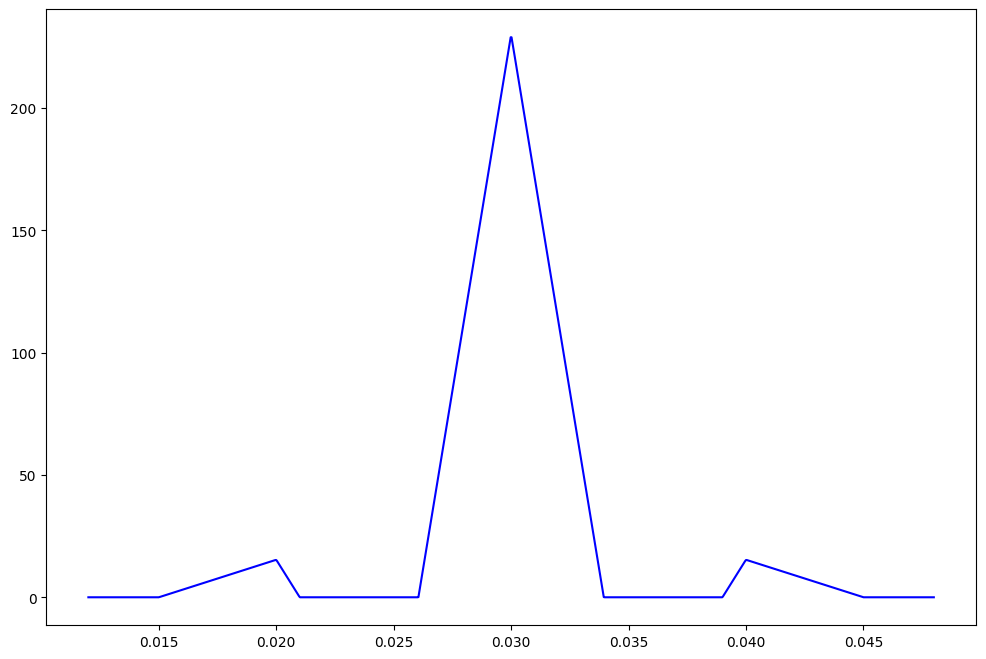

In [33]:
# Compute the forward implied distribution
try:
    result = compute_forward_implied_distribution(
        strikes_t1=strikes_t1,
        vols_t1=vols_t1,
        strikes_t2=strikes_t2, 
        vols_t2=vols_t2,
        forward_t0=forward_t0,
        move_at_t1=move_at_t1,
        t1=t1,
        t2=t2
    )
    
    print("\n" + "="*60)
    print("FORWARD IMPLIED DISTRIBUTION RESULTS")
    print("="*60)
    
    print(f"\nForward at T={t1} after {move_at_t1*10000:.0f}bp move: {result['forward_t1']:.1%}")
    print(f"Expected forward at T={t2} given the move: {result['conditional_forward_t2']:.1%}")
    
    diag = result['diagnostics']
    print(f"\nDiagnostics:")
    print(f"  ATM vol at T={t1}: {diag['vol_t1_atm']:.0f}bp")
    print(f"  ATM vol at T={t2}: {diag['vol_t2_atm']:.0f}bp")
    print(f"  Implied forward vol (T={t1} to T={t2}): {diag['forward_vol']:.0f}bp")
    print(f"  Forward standard deviation: {diag['forward_std']*10000:.0f}bp")
    print(f"  Probability density at T={t1} move: {diag['prob_at_t1']:.2e}")
    
except Exception as e:
    print(f"Error computing forward distribution: {e}")
    result = None

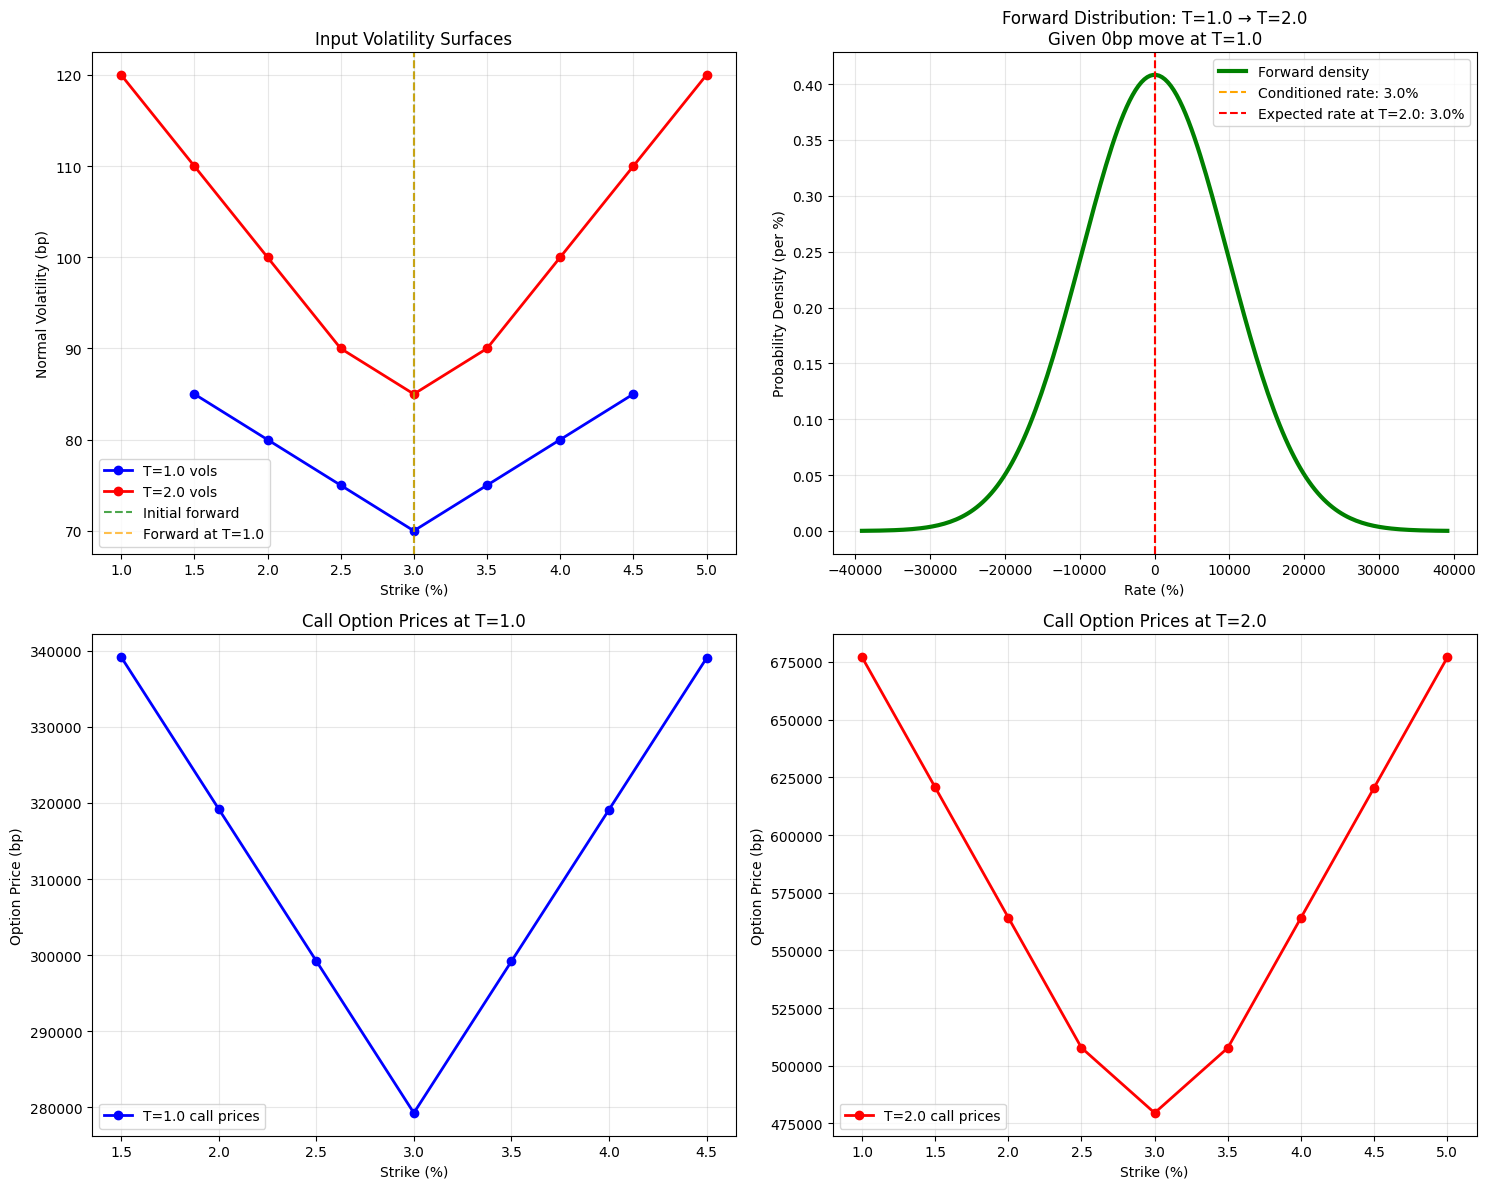


Forward Distribution Percentiles (at T=2.0):
   5th percentile: -15907.9% (-1591086bp from T=1.0 rate)
  25th percentile: -6479.2% (-648220bp from T=1.0 rate)
  50th percentile: -193.4% (-19643bp from T=1.0 rate)
  75th percentile: 6485.2% (+648220bp from T=1.0 rate)
  95th percentile: 15913.9% (+1591086bp from T=1.0 rate)

Probabilities:
  P(Rate at T=2.0 > Initial rate 3.0%) = 49.2%
  P(Rate at T=2.0 > Rate at T=1.0 3.0%) = 49.2%


In [31]:
if result is not None:
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Volatility surfaces
    ax1.plot(strikes_t1 * 100, vols_t1, 'bo-', label=f'T={t1} vols', linewidth=2, markersize=6)
    ax1.plot(strikes_t2 * 100, vols_t2, 'ro-', label=f'T={t2} vols', linewidth=2, markersize=6)
    ax1.axvline(forward_t0 * 100, color='green', linestyle='--', alpha=0.7, label='Initial forward')
    ax1.axvline(result['forward_t1'] * 100, color='orange', linestyle='--', alpha=0.7, label=f'Forward at T={t1}')
    ax1.set_xlabel('Strike (%)')
    ax1.set_ylabel('Normal Volatility (bp)')
    ax1.set_title('Input Volatility Surfaces')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Forward distribution
    ax2.plot(result['forward_strikes'] * 100, result['forward_density'] * 100, 
             'g-', linewidth=3, label='Forward density')
    ax2.axvline(result['forward_t1'] * 100, color='orange', linestyle='--', 
                label=f'Conditioned rate: {result["forward_t1"]:.1%}')
    ax2.axvline(result['conditional_forward_t2'] * 100, color='red', linestyle='--',
                label=f'Expected rate at T={t2}: {result["conditional_forward_t2"]:.1%}')
    ax2.set_xlabel('Rate (%)')
    ax2.set_ylabel('Probability Density (per %)')
    ax2.set_title(f'Forward Distribution: T={t1} → T={t2}\nGiven {move_at_t1*10000:.0f}bp move at T={t1}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Option prices at T=1
    call_prices_t1_display = [normal_option_price(forward_t0, k, vol, t1, 'call') 
                             for k, vol in zip(strikes_t1, vols_t1)]
    ax3.plot(strikes_t1 * 100, np.array(call_prices_t1_display) * 10000, 'bo-', 
             linewidth=2, markersize=6, label=f'T={t1} call prices')
    ax3.set_xlabel('Strike (%)')
    ax3.set_ylabel('Option Price (bp)')
    ax3.set_title(f'Call Option Prices at T={t1}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Option prices at T=2
    call_prices_t2_display = [normal_option_price(forward_t0, k, vol, t2, 'call') 
                             for k, vol in zip(strikes_t2, vols_t2)]
    ax4.plot(strikes_t2 * 100, np.array(call_prices_t2_display) * 10000, 'ro-', 
             linewidth=2, markersize=6, label=f'T={t2} call prices')
    ax4.set_xlabel('Strike (%)')
    ax4.set_ylabel('Option Price (bp)')
    ax4.set_title(f'Call Option Prices at T={t2}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    forward_strikes = result['forward_strikes']
    forward_density = result['forward_density']
    
    # Calculate percentiles
    cdf = np.cumsum(forward_density) * (forward_strikes[1] - forward_strikes[0])
    percentiles = [5, 25, 50, 75, 95]
    pct_values = []
    
    for p in percentiles:
        idx = np.searchsorted(cdf, p/100)
        if idx < len(forward_strikes):
            pct_values.append(forward_strikes[idx])
        else:
            pct_values.append(forward_strikes[-1])
    
    print(f"\nForward Distribution Percentiles (at T={t2}):")
    for p, v in zip(percentiles, pct_values):
        print(f"  {p:2d}th percentile: {v:.1%} ({(v-result['forward_t1'])*10000:+.0f}bp from T={t1} rate)")
    
    # Calculate probability of being above/below certain levels
    prob_above_initial = np.trapz(
        forward_density[forward_strikes > forward_t0], 
        forward_strikes[forward_strikes > forward_t0]
    )
    prob_above_t1 = np.trapz(
        forward_density[forward_strikes > result['forward_t1']], 
        forward_strikes[forward_strikes > result['forward_t1']]
    )
    
    print(f"\nProbabilities:")
    print(f"  P(Rate at T={t2} > Initial rate {forward_t0:.1%}) = {prob_above_initial:.1%}")
    print(f"  P(Rate at T={t2} > Rate at T={t1} {result['forward_t1']:.1%}) = {prob_above_t1:.1%}")

## Methodology Explanation

The forward implied distribution calculation involves several key steps:

### 1. **Extract Risk-Neutral Densities**
   - From T=1 and T=2 option prices, we extract the risk-neutral probability densities
   - Using the relationship: density = d²(option_price)/dK² 
   - Numerical differentiation with smoothing (cubic spline interpolation)

### 2. **Forward Volatility Calculation**
   - The forward volatility from T=1 to T=2 is derived from the term structure:
   - σ²(T₂) × T₂ = σ²(T₁) × T₁ + σ²_forward × (T₂ - T₁)
   - This gives us: σ_forward = √[(σ²(T₂) × T₂ - σ²(T₁) × T₁) / (T₂ - T₁)]

### 3. **Conditional Distribution**
   - Given a specific move at T=1, we condition the distribution
   - Under the normal model, the forward distribution is:
   - Rate(T₂) | Rate(T₁) ~ Normal(Rate(T₁), σ_forward × √(T₂ - T₁))

### 4. **Key Assumptions**
   - Normal (Bachelier) model for interest rate options
   - Independent increments (Markovian evolution)
   - Constant forward volatility between T₁ and T₂

### 5. **Practical Considerations**
   - The method works best when the move at T=1 is within reasonable bounds
   - Vol smile effects are captured through the input volatility surfaces
   - Results should be validated against market intuition and cross-checked with other methods


Running sensitivity analysis...


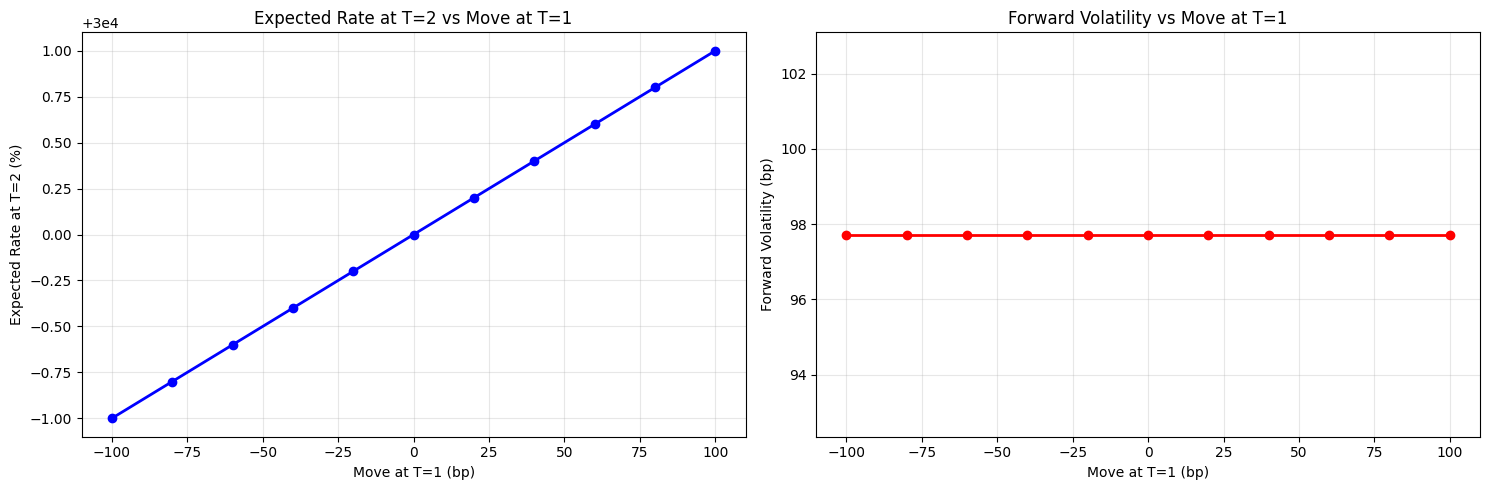


Sensitivity Analysis Results:
Move Range: -100bp to 100bp
Expected Rate Range: 29999.0% to 30001.0%
Forward Vol Range: 98bp to 98bp


In [15]:
def analyze_move_sensitivity(strikes_t1, vols_t1, strikes_t2, vols_t2, forward_t0, 
                           t1=1.0, t2=2.0, move_range_bp=100, num_moves=11):
    """
    Analyze how the forward distribution changes for different moves at T=1.
    """
    moves_bp = np.linspace(-move_range_bp, move_range_bp, num_moves)
    moves = moves_bp / 10000  # Convert to decimal
    
    results = []
    expected_rates = []
    forward_vols = []
    
    for move in moves:
        try:
            result = compute_forward_implied_distribution(
                strikes_t1, vols_t1, strikes_t2, vols_t2, 
                forward_t0, move, t1, t2
            )
            results.append(result)
            expected_rates.append(result['conditional_forward_t2'])
            forward_vols.append(result['diagnostics']['forward_vol'])
        except:
            results.append(None)
            expected_rates.append(np.nan)
            forward_vols.append(np.nan)
    
    return moves_bp, expected_rates, forward_vols, results

# Run sensitivity analysis
print("\nRunning sensitivity analysis...")
moves_bp, expected_rates, forward_vols, sensitivity_results = analyze_move_sensitivity(
    strikes_t1, vols_t1, strikes_t2, vols_t2, forward_t0
)

# Plot sensitivity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Expected rates
valid_mask = ~np.isnan(expected_rates)
ax1.plot(moves_bp[valid_mask], np.array(expected_rates)[valid_mask] * 100, 'bo-', linewidth=2)
ax1.set_xlabel('Move at T=1 (bp)')
ax1.set_ylabel('Expected Rate at T=2 (%)')
ax1.set_title('Expected Rate at T=2 vs Move at T=1')
ax1.grid(True, alpha=0.3)

# Forward volatilities
ax2.plot(moves_bp[valid_mask], np.array(forward_vols)[valid_mask], 'ro-', linewidth=2)
ax2.set_xlabel('Move at T=1 (bp)')
ax2.set_ylabel('Forward Volatility (bp)')
ax2.set_title('Forward Volatility vs Move at T=1')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSensitivity Analysis Results:")
print(f"Move Range: {moves_bp[0]:.0f}bp to {moves_bp[-1]:.0f}bp")
print(f"Expected Rate Range: {np.nanmin(expected_rates):.1%} to {np.nanmax(expected_rates):.1%}")
print(f"Forward Vol Range: {np.nanmin(forward_vols):.0f}bp to {np.nanmax(forward_vols):.0f}bp")

## Usage Instructions

To use this framework with your own data:

### 1. **Prepare Your Data**
```python
# Your volatility surfaces
strikes_t1 = np.array([...])  # Strikes for T=1 options
vols_t1 = np.array([...])     # Normal vols in basis points for T=1
strikes_t2 = np.array([...])  # Strikes for T=2 options  
vols_t2 = np.array([...])     # Normal vols in basis points for T=2

# Market parameters
forward_t0 = 0.03           # Current forward rate (3%)
move_at_t1 = 0.005          # Move at T=1 (+50bp)
```

### 2. **Compute Forward Distribution**
```python
result = compute_forward_implied_distribution(
    strikes_t1, vols_t1, strikes_t2, vols_t2,
    forward_t0, move_at_t1, t1=1.0, t2=2.0
)
```

### 3. **Access Results**
```python
forward_density = result['forward_density']     # Probability density
forward_strikes = result['forward_strikes']     # Strike grid
expected_rate = result['conditional_forward_t2'] # Expected rate at T=2
```

## Next Steps and Extensions

1. **Enhanced Models**: Implement stochastic volatility models (e.g., SABR) for more sophisticated vol dynamics
2. **Smile Dynamics**: Better modeling of how vol smile evolves forward in time
3. **Multi-Factor Models**: Include correlation with other rates/factors
4. **Calibration**: Fit model parameters to market data
5. **Risk Management**: Use distributions for VaR, scenario analysis, etc.
6. **Validation**: Compare with Monte Carlo simulations or other analytical methods